In [1]:
pip install numpy pandas scikit-learn tensorflow matplotlib

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: /srv/jupyter/python-venv/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Reshape
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error
from datetime import timedelta


2024-10-07 13:28:36.821478: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-07 13:28:36.855374: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-07 13:28:36.989380: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-07 13:28:37.013814: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-07 13:28:37.064439: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [3]:
# Load the weather data
data = pd.read_csv('combined_weather_data.csv')

# Convert the Year, Month, Day columns into a single datetime column
data['date'] = pd.to_datetime(data[['Year', 'Month', 'Day']])
data.set_index('date', inplace=True)
data.drop(columns=['Year', 'Month', 'Day'], inplace=True)

# Select features for prediction
features = ['Min Temp', 'Max Temp', 'Humidity', 'Pressure', 'Precipitation']
data = data[features]

# Scale the data between 0 and 1
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
scaled_df = pd.DataFrame(scaled_data, columns=features, index=data.index)

# Split the data into training and testing sets (80% training, 20% testing)
train_size = int(len(scaled_df) * 0.8)
train_data = scaled_df[:train_size]
test_data = scaled_df[train_size:]


In [4]:
train_data , test_data

(            Min Temp  Max Temp  Humidity  Pressure  Precipitation
 date                                                             
 2000-01-01  0.382166  0.300699  0.483333  0.850932       0.000000
 2000-01-02  0.414013  0.335664  0.450000  0.850932       0.000000
 2000-01-03  0.382166  0.307692  0.500000  0.838509       0.000000
 2000-01-04  0.350318  0.300699  0.500000  0.844720       0.000000
 2000-01-05  0.350318  0.300699  0.500000  0.850932       0.000000
 ...              ...       ...       ...       ...            ...
 2019-10-05  0.866242  0.601399  0.783333  0.813665       0.011359
 2019-10-06  0.866242  0.580420  0.783333  0.819876       0.027586
 2019-10-07  0.815287  0.524476  0.800000  0.826087       0.066126
 2019-10-08  0.796178  0.538462  0.700000  0.826087       0.064097
 2019-10-09  0.783439  0.433566  0.916667  0.826087       0.117647
 
 [6985 rows x 5 columns],
             Min Temp  Max Temp  Humidity  Pressure  Precipitation
 date                             

In [5]:
# Create sequences
def create_sequences(data, sequence_length, prediction_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length - prediction_length + 1):
        seq = data.iloc[i:i + sequence_length].values
        label = data.iloc[i + sequence_length: i + sequence_length + prediction_length].values
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Define sequence and prediction lengths
sequence_length = 366  # Input sequence 
prediction_length = 366  # Predict the next 

# Create sequences for training and testing
X_train, y_train = create_sequences(train_data, sequence_length, prediction_length)
X_test, y_test = create_sequences(test_data, sequence_length, prediction_length)

# Ensure the data type is float32
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.float32)

# Check the shape of the generated sequences and labels
print("X_train shape:", X_train.shape)  # Should be (samples, sequence_length, num_features)
print("y_train shape:", y_train.shape)  # Should be (samples, prediction_length, num_features)


X_train shape: (6254, 366, 5)
y_train shape: (6254, 366, 5)


In [6]:
# Define the LSTM model
model = Sequential()
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))  # Input layer
model.add(LSTM(200, return_sequences=True))  # LSTM with return_sequences=True
model.add(Dropout(0.2))

model.add(LSTM(100, return_sequences=False))  # Another LSTM layer
model.add(Dropout(0.2))

model.add(Dense(prediction_length * X_train.shape[2]))  # Adjust based on total outputs // output layer
model.add(tf.keras.layers.Reshape((prediction_length, X_train.shape[2])))  # Reshape to (90, 5)

# Compile the model with a lower learning rate (e.g., 0.0005)
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')

# Summary of the model
model.summary()

# Set up callbacks for early stopping and model checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 366, 400)       │       649,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 366, 400)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 366, 200)       │       480,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 366, 200)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 100)            │       120,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1830)           │       184,830 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 366, 5)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,435,630 (5.48 MB)

 Trainable params: 1,435,630 (5.48 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# Train the model and save the history
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping, model_checkpoint])


Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 90s 4s/step - loss: 0.0175 - val_loss: 0.0163
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 90s 4s/step - loss: 0.0173 - val_loss: 0.0159
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 90s 4s/step - loss: 0.0171 - val_loss: 0.0160
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 90s 4s/step - loss: 0.0170 - val_loss: 0.0162
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 90s 4s/step - loss: 0.0169 - val_loss: 0.0160
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 91s 4s/step - loss: 0.0168 - val_loss: 0.0161
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 91s 4s/step - loss: 0.0167 - val_loss: 0.0159
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 90s 4s/step - loss: 0.0166 - val_loss: 0.0160
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 89s 4s/step - loss: 0.0165 - val_loss: 0.0160
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 90s 4s/step - loss: 0.0165 - val_loss: 0.0161
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 90s 4s/step - loss: 0.0164 - val_loss: 0.0159
Epoch 12/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 91s 4s/step - loss: 0.0164 - val_lo

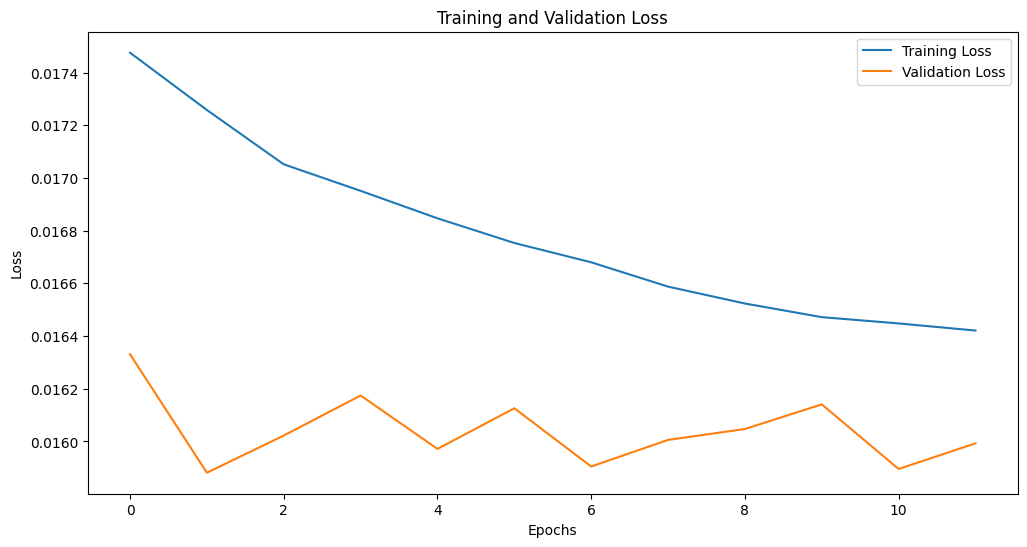

In [25]:
# Plot the training and validation loss
plt.figure(figsize=(12, 6))  # Optional: Set figure size
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 441ms/step


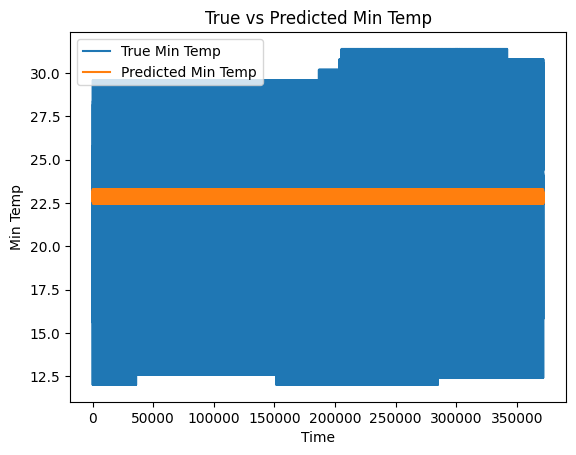

In [27]:
# Make predictions
predictions = model.predict(X_test)

# Reshape the predicted values to match the test data shape
predicted_data = predictions.reshape(-1, predictions.shape[-1])

# Rescale the predicted values back to their original scale
predicted_data_rescaled = scaler.inverse_transform(predicted_data)

# Reshape the test data to match the predicted shape
y_test_reshaped = y_test.reshape(-1, y_test.shape[-1])

# Rescale the test data back to its original scale for comparison
true_data_rescaled = scaler.inverse_transform(y_test_reshaped)

# Plot the actual vs predicted values for one feature (e.g., Min Temp)
plt.figure(figsize=(10, 6))
plt.plot(true_data_rescaled[:, 0], label='True Min Temp')
plt.plot(predicted_data_rescaled[:, 0], label='Predicted Min Temp')
plt.title('True vs Predicted Min Temp')
plt.xlabel('Time')
plt.ylabel('Min Temp')
plt.legend()
plt.show()


In [28]:
# Reshape the test and predicted data
predicted_data = predictions.reshape(-1, predictions.shape[-1])
true_data_reshaped = y_test.reshape(-1, y_test.shape[-1])

# Rescale the predicted and true data back to their original scales
predicted_data_rescaled = scaler.inverse_transform(predicted_data)
true_data_rescaled = scaler.inverse_transform(true_data_reshaped)

# Calculate the errors for one feature (e.g., Min Temp, which is index 0)
mae = mean_absolute_error(true_data_rescaled[:, 0], predicted_data_rescaled[:, 0])
rmse = np.sqrt(mean_squared_error(true_data_rescaled[:, 0], predicted_data_rescaled[:, 0]))

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')


Mean Absolute Error (MAE): 4.318721771240234
Root Mean Squared Error (RMSE): 4.844549179077148


In [33]:
# Use the last sequence from the test data to predict future weather
last_sequence = X_test[-1].reshape(1, X_test.shape[1], X_train.shape[2])  # Ensure correct shape

# Predict future weather (for the next 90 days, for example)
future_prediction = model.predict(last_sequence)

# Reshape the predicted data to 2D for inverse transformation (batch size is 1, so we remove it)
future_prediction_reshaped = future_prediction.reshape(future_prediction.shape[1], future_prediction.shape[2])

# Inverse transform the prediction back to the original scale
future_weather = scaler.inverse_transform(future_prediction_reshaped)

print(f"Predicted future weather for the next {len(future_weather)} days: \n{future_weather}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Predicted future weather for the next 366 days: 
[[  22.679441    31.675047    74.33938   1006.52185      4.4021134]
 [  22.75183     31.680986    74.33032   1006.6277       3.4908886]
 [  22.70014     31.684202    74.301216  1007.12823      3.6009138]
 ...
 [  22.823236    31.698208    74.542625  1007.31415      4.502896 ]
 [  22.85699     31.854961    74.60527   1006.99664      4.998435 ]
 [  22.874468    31.709097    74.853516  1006.7694       3.8348563]]


In [7]:
# Load the trained model
model = load_model('best_model.keras')

# Use the last sequence from the test data to predict future weather
last_sequence = X_test[-1].reshape(1, X_test.shape[1], X_train.shape[2])  # Ensure correct shape

# Predict future weather (for the next 90 days, for example)
future_prediction = model.predict(last_sequence)

# Reshape the predicted data to 2D for inverse transformation (batch size is 1, so we remove it)
future_prediction_reshaped = future_prediction.reshape(future_prediction.shape[1], future_prediction.shape[2])

# Inverse transform the prediction back to the original scale
future_weather = scaler.inverse_transform(future_prediction_reshaped)

print(f"Predicted future weather for the next {len(future_weather)} days: \n{future_weather}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
Predicted future weather for the next 366 days: 
[[  22.679441    31.675047    74.33938   1006.52185      4.4021134]
 [  22.75183     31.680986    74.33032   1006.6277       3.4908886]
 [  22.70014     31.684202    74.301216  1007.12823      3.6009138]
 ...
 [  22.823236    31.698208    74.542625  1007.31415      4.502896 ]
 [  22.85699     31.854961    74.60527   1006.99664      4.998435 ]
 [  22.874468    31.709097    74.853516  1006.7694       3.8348563]]


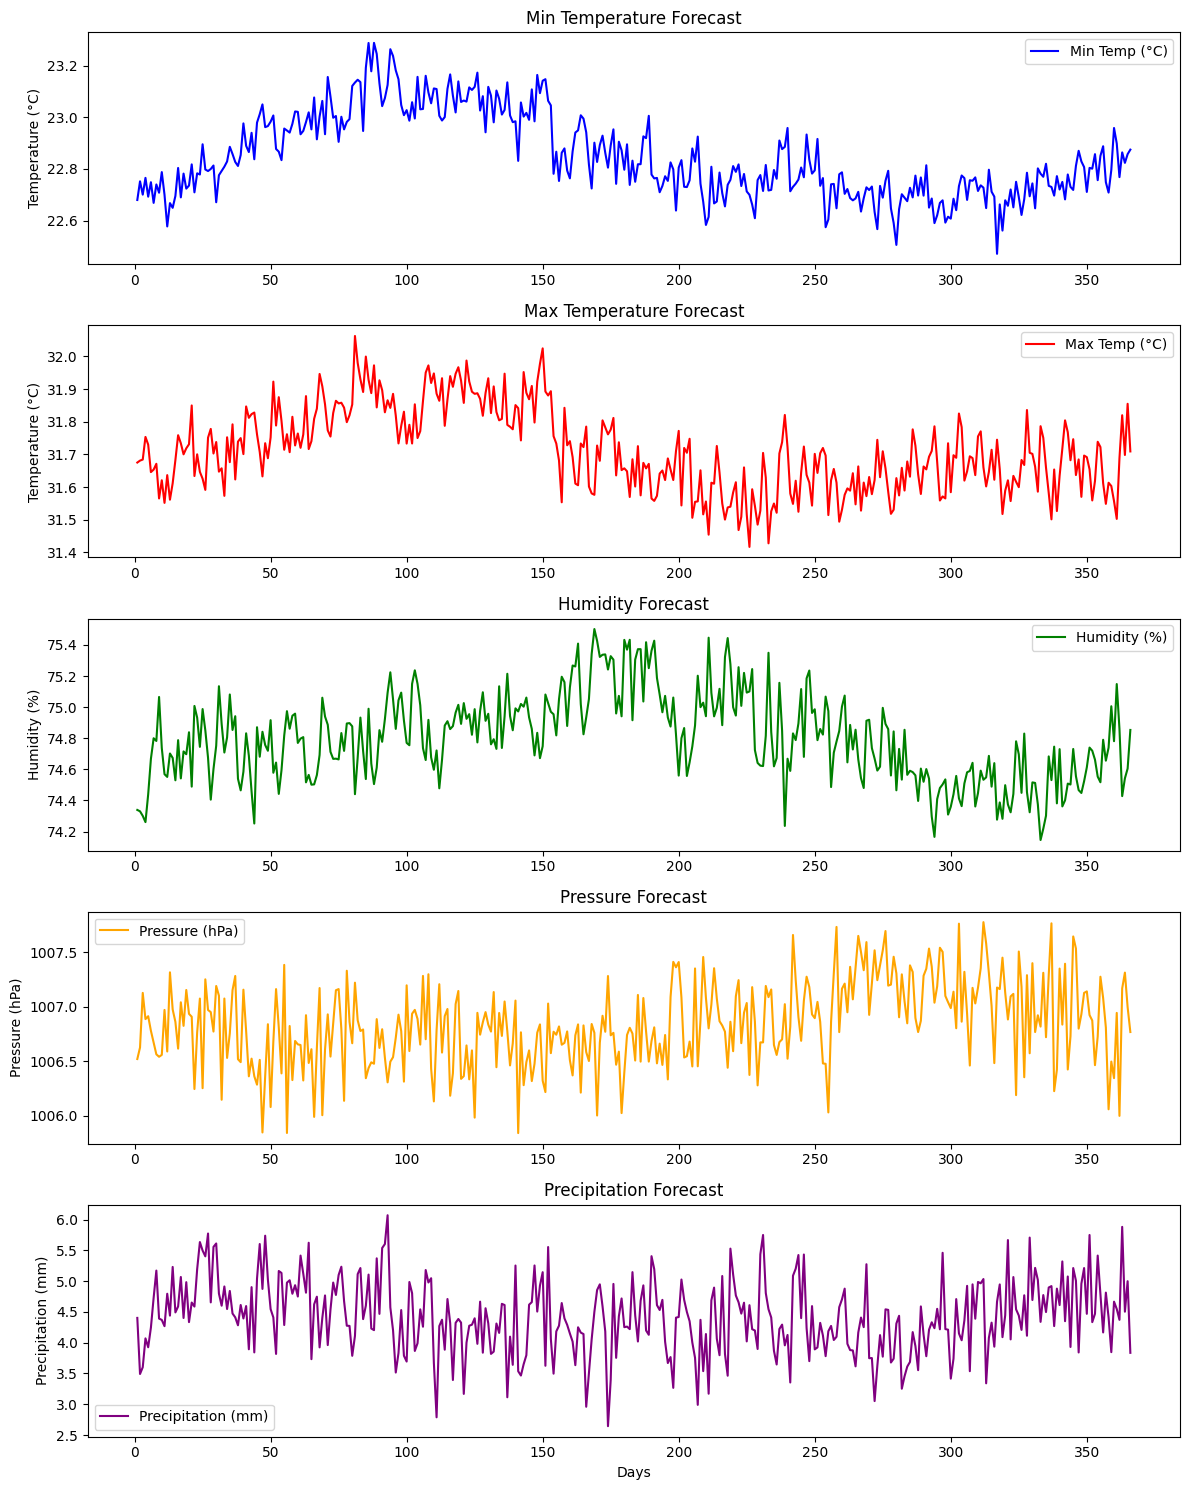

In [8]:
days = np.arange(1, len(future_weather) + 1)

# Extracting each weather feature
min_temp = future_weather[:, 0]   # First column for Min Temp
max_temp = future_weather[:, 1]   # Second column for Max Temp
humidity = future_weather[:, 2]   # Third column for Humidity
pressure = future_weather[:, 3]   # Fourth column for Pressure
precipitation = future_weather[:, 4]  # Fifth column for Precipitation

# Creating individual plots for each weather feature
plt.figure(figsize=(12, 15))

# Plot for Min Temperature
plt.subplot(5, 1, 1)
plt.plot(days, min_temp, label='Min Temp (°C)', color='blue')
plt.title('Min Temperature Forecast')
plt.ylabel('Temperature (°C)')
plt.legend()

# Plot for Max Temperature
plt.subplot(5, 1, 2)
plt.plot(days, max_temp, label='Max Temp (°C)', color='red')
plt.title('Max Temperature Forecast')
plt.ylabel('Temperature (°C)')
plt.legend()

# Plot for Humidity
plt.subplot(5, 1, 3)
plt.plot(days, humidity, label='Humidity (%)', color='green')
plt.title('Humidity Forecast')
plt.ylabel('Humidity (%)')
plt.legend()

# Plot for Pressure
plt.subplot(5, 1, 4)
plt.plot(days, pressure, label='Pressure (hPa)', color='orange')
plt.title('Pressure Forecast')
plt.ylabel('Pressure (hPa)')
plt.legend()

# Plot for Precipitation
plt.subplot(5, 1, 5)
plt.plot(days, precipitation, label='Precipitation (mm)', color='purple')
plt.title('Precipitation Forecast')
plt.ylabel('Precipitation (mm)')
plt.xlabel('Days')
plt.legend()

plt.tight_layout()  # Adjust subplots to fit into the figure area
plt.show()

In [17]:
print(len(last_sequence[0]))

366


In [ ]:
# Load the trained model
model = load_model('best_model.keras')

# Function to predict the next days using the last 366 days of data
def predict_next_days(data, model, sequence_length=366, prediction_length=366):
    # Ensure you have the last sequence_length days of data
    input_data = data[-sequence_length:].values
    input_data = input_data.reshape(1, input_data.shape[0], input_data.shape[1])  # Reshape for model input
    predicted_data = model.predict(input_data)
    return predicted_data[0]  # Return predictions for the next days

# Function to update the model with new data and predict the remaining days
def update_and_predict(scaled_df, actual_data_today, model, future_days_left, scaler):
    # Append today's actual data (scaled)
    scaled_actual_today = scaler.transform([actual_data_today])
    new_today_index = pd.to_datetime('today').normalize()
    scaled_df = pd.concat([scaled_df, pd.DataFrame(scaled_actual_today, index=[new_today_index])])

    # Predict the remaining days
    if future_days_left < 300:
        # When fewer than 300 predicted days remain, re-predict a full 366 days
        predicted_data = predict_next_days(scaled_df, model, sequence_length=366, prediction_length=366)
        future_days_left = 366
    else:
        # Predict remaining days
        predicted_data = predict_next_days(scaled_df, model, sequence_length=366, prediction_length=future_days_left)
    
    # Attach dates to predictions
    last_actual_date = scaled_df.index[-1]
    predicted_dates = [last_actual_date + timedelta(days=i) for i in range(1, future_days_left + 1)]
    
    # Convert the predictions back to the original scale
    predicted_df = pd.DataFrame(predicted_data, index=predicted_dates, columns=scaled_df.columns)
    predicted_df = pd.DataFrame(scaler.inverse_transform(predicted_df), index=predicted_dates, columns=scaled_df.columns)

    # Update future days left
    future_days_left -= 1

    return predicted_df, future_days_left

# Example of how to use the function
# Initial prediction (after model is trained)
scaled_df = pd.DataFrame(scaled_data, index=data.index, columns=features)  # Already scaled weather data
predicted_df, future_days_left = predict_next_days(scaled_df, model)

# Each day, you will update with the actual data for today and predict the next days
actual_data_today = [25.0, 35.0, 60.0, 1010.0, 5.0]  # Example new actual data (unscaled)
predicted_df, future_days_left = update_and_predict(scaled_df, actual_data_today, model, future_days_left, scaler)

# Now, `predicted_df` contains the predictions for the next days along with their corresponding dates.
print(predicted_df)
